Each models is required to generate a stack ranking of all properties listed for sale in the database.

This script takes in a ranking from X months ago, and calculates how many homes have successfully sold and if it was a good sale or not. It then outputs what % of homes in each percentile successfully sold and what % of those were good sells. It should repeat it on several other rankings to get a higher count of properties

In [19]:
import pandas as pd
import numpy as np
import datetime as dt
import os
from slacker import Slacker
import json
import requests
from cloudinary.uploader import upload
from cloudinary.utils import cloudinary_url
from cloudinary.api import delete_resources_by_tag, resources_by_tag

csv_path = '/home/ilya/Code/rentalnerd/scraper/'
today = dt.date.today()


%matplotlib inline
        
# slack secrets (in your ~/.bashrc)
webhook_url = os.environ.get('SLACK_URL')
slacker = Slacker(os.environ.get('SLACK_TOKEN'))

pd.set_option('display.max_colwidth', -1)
discount = 0.050

In [20]:
def plot_rounds(plot):
    # uploads the graph to the web and returns the URL
    
    fig = plot.get_figure()
    fig.tight_layout()
    fig.savefig('temp_plot.png')
    
    response = upload("temp_plot.png")
    url, options = cloudinary_url(response['public_id'],
        format = response['format'],
        crop = "fill")
    return url

In [21]:
def slack(text, url = None, title = None):
    print("Slacking: " + text)
    
    if url == None:
        data=json.dumps({"text": text})
    else:
        data = json.dumps( { "text": text, "attachments": [ { "fallback": "Model MAE"
                                           , "title": title
                                           , "image_url": url } ] } )
    
    response = requests.post(webhook_url, data , headers={'Content-Type': 'application/json'})
    if response.status_code != 200:
        raise ValueError('Request to slack returned an error %s, the response is:\n%s' % (response.status_code, response.text))


In [22]:
closed = pd.read_csv('CSV_backups/ALL-sales.csv',nrows=10000000, index_col=['property_id','transaction_id'])

/home/ilya/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (13,14,15,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [23]:
closed.head()

price transaction_status date_listed  \
property_id transaction_id                                          
9025615     23856143        155000  closed             2013-10-06   
            23856139        75250   closed             NaN          
            23856138        53000   closed             2011-02-10   
            23856136        137614  closed             NaN          
            23856135        150000  closed             NaN          

                            date_closed  days_on_market transaction_type  \
property_id transaction_id                                                 
9025615     23856143        5083         56.0            sales             
            23856139        4268        NaN              sales             
            23856138        4065         7.0             sales             
            23856136        3937        NaN              sales             
            23856135        2928        NaN              sales             

                            is_latest  price_listed  price_closed  \
property_id transaction_id                                          
9025615     23856143        False      159900.0      155000         
            23856139        False     NaN            75250          
            23856138        False      60900.0       53000          
            23856136        False     NaN            137614         
            23856135        False     NaN            150000         

                           date_transacted_latest          ...            \
property_id transaction_id                                 ...             
9025615     23856143        2013-12-01                     ...             
            23856139        2011-09-08                     ...             
            23856138        2011-02-17                     ...             
            23856136        2010-10-12                     ...             
            23856135        2008-01-07                     ...             

                            school_district_id_57.0  school_district_id_60.0  \
property_id transaction_id                                                     
9025615     23856143        0                        0                         
            23856139        0                        0                         
            23856138        0                        0                         
            23856136        0                        0                         
            23856135        0                        0                         

                           school_district_id_67.0 school_district_id_68.0  \
property_id transaction_id                                                   
9025615     23856143        0                       0                        
            23856139        0                       0                        
            23856138        0                       0                        
            23856136        0                       0                        
            23856135        0                       0                        

                           school_district_id_75.0  school_district_id_87.0  \
property_id transaction_id                                                    
9025615     23856143        0                       0                         
            23856139        0                       0                         
            23856138        0                       0                         
            23856136        0                       0                         
            23856135        0                       0                         

                           school_district_id_90.0 school_district_id_93.0  \
property_id transaction_id                                                   
9025615     23856143        0                       0                        
            23856139        0                       0                        
            23856138 

In [43]:
# read in prior target list for backtesting purposes
good_sell_results = np.empty([0,11])
discount_results = np.empty([0,11])
sell_cnt_results = np.empty([0,11])
bins = pd.DataFrame({'A' : []})
for lag_days in range(60,59,-1):
    try:
        prior_target_list = pd.read_csv(csv_path + 'good_sell/gs_target_list_' + (today-dt.timedelta(days=lag_days)) \
                                    .strftime('%Y%m%d') + '.csv', index_col = [0,1]) \
                                    .rename(columns = { 'ypred' : 'good_sell_prob'})

        backtest = prior_target_list.join(closed[['price']], how="left").sort_values(by='good_sell_prob',ascending=False)

        backtest['discount'] = 1 - backtest.price / backtest.list
        backtest['good_sell'] = backtest.apply(lambda row: row.discount < discount if not pd.isnull(row.price) else np.NaN, axis=1)
        backtest['outcome'] = backtest.apply(lambda row: "no_sell" if pd.isnull(row.price) else "good_sell" if row.good_sell else "bad_sell", axis=1)
            
        backtest['probability_bin'] = pd.qcut(backtest.good_sell_prob, np.arange(0,1.1,0.1),duplicates='drop')
        fn = 'good_sell_backtest_days_' + (today-dt.timedelta(days=lag_days)).strftime('%Y%m%d') + '.csv'
        print("Saving file %s" % fn)
        backtest.to_csv(fn)
        
          
        grouped = backtest[['probability_bin','good_sell','discount','list']].astype('float').groupby('probability_bin')
        print(grouped.mean())
        print(grouped.count())
#         print(grouped.good_sell.count() / grouped.list.count())


        # store results in arrays for graphing
        print(grouped.good_sell.mean())
        r = np.append(lag_days,grouped.good_sell.mean().values)
        r = np.reshape(r,(1,11))
        good_sell_results = np.append(good_sell_results,r,axis=0)
        
        r = np.append(lag_days,grouped.discount.mean().values)
        r = np.reshape(r,(1,11))
        discount_results = np.append(discount_results,r,axis=0)
        
#         r = np.append(lag_days,(grouped.good_sell.count() / grouped.list.count()).values)
#         r = np.reshape(r,(1,11))
#         sell_cnt_results = np.append(sell_cnt_results,r,axis=0)
        
        
        
#         y_all = prior_target_list.good_sell_prob.mean()
#         y_sold = backtest.good_sell_prob.mean()

#         pos_trigger = prior_target_list.good_sell_prob.quantile(0.75)
#         slack("Prior target list length: %i\tNum sold: %i\tAvg good sell prob: %f\tAvg good sell prob of sold: %f" 
#               % (len(prior_target_list.index), len(backtest.index),y_all, y_sold))

#         num_pos = len(prior_target_list[prior_target_list.good_sell_prob > pos_trigger].index)
#         positives = backtest[backtest.good_sell_prob > pos_trigger]
#         y_pos = (-(positives.price - positives.list) / positives.list).median()
#         num_sold = len(positives.index)
#         if num_sold == 0:
#             slack("Num of homes with good_sell_prob > %f: %i\tPerc of those sold: NONE\tMed disc to list: NA" % (pos_trigger, num_pos) )    
#         else:
#             slack("Num of homes with good_sell_prob > %f: %i\tPerc of those sold: %f\tMed disc to list: %f" 
#                   % (pos_trigger, num_pos, num_sold / num_pos *  100, y_pos * 100))

#         neg_trigger = prior_target_list.good_sell_prob.quantile(0.25)
#         num_neg = len(prior_target_list[prior_target_list.good_sell_prob < neg_trigger].index)
#         negatives = backtest[backtest.good_sell_prob < neg_trigger]
#         y_neg = (-(negatives.price - negatives.list) / negatives.list).median()
#         num_sold = len(negatives.index)

#         if num_sold == 0:
#             slack("Num of homes with good_sell_prob < %f: %i\tPerc of those sold: NONE\tMedian disc to list: NA" % (neg_trigger, num_neg))
#         else:
#             slack("Num of homes with good_sell_prob < %f: %i\tPerc of those sold: %f\tMedian disc to list:%f" 
#                   % (neg_trigger, num_neg, len(negatives.index) / num_neg * 100, y_neg * 100))

#         slack(backtest.to_string())
#         backtest.to_csv("median_check.csv")
#         # store results in arrays for graphing
#         r = np.array([[lag_days, len(prior_target_list.index), len(backtest.index), num_sold / num_pos * 100, y_pos * 100, len(negatives.index) / num_neg * 100, y_neg * 100]])
#         model_results = np.append(model_results,r,axis=0)
        
    except Exception as err:   
        print(err)

Saving file good_sell_backtest_days_20171017.csv
float() argument must be a string or a number, not 'pandas._libs.interval.Interval'


[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]


/home/ilya/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
/home/ilya/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/home/ilya/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/home/ilya/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: Mean of empty slice
/home/ilya/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: Mean of empty slice
/home/ilya/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: Mean of empty slice


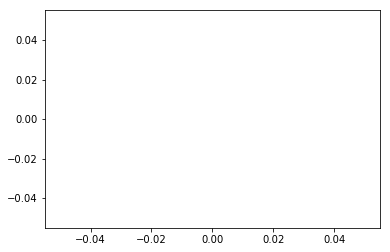

In [7]:
print(np.nanmean(good_sell_results, axis=0)[1:])
print(np.nanmean(discount_results, axis=0)[1:])
print(np.nanmean(sell_cnt_results, axis=0)[1:])

import matplotlib.pyplot as plt
plt.plot(np.nanmean(good_sell_results, axis=0)[1:])
plt.plot(np.nanmean(discount_results, axis=0)[1:])
plt.plot(np.nanmean(sell_cnt_results, axis=0)[1:])



In [8]:
# read in prior target list for backtesting purposes
model_results = np.empty([0,7])
for lag_days in range(1,2):
    print("Lag days %i\n\n" % lag_days)
    try:
        prior_target_list = pd.read_csv(csv_path + 'neural_network/nn_target_list_' + (today-dt.timedelta(days=lag_days)) \
                                    .strftime('%Y%m%d') + '.csv', index_col = [0,1]) \
                                    .rename(columns = { 'ypred' : 'good_sell_prob'})

        backtest = prior_target_list.join(closed[['price']], how="inner").sort_values(by='good_sell_prob',ascending=False)
        backtest['good_sell'] = (backtest.price >= (backtest.list * (1-discount)))
        y_all = prior_target_list.good_sell_prob.mean()
        y_sold = backtest.good_sell_prob.mean()

        pos_trigger = prior_target_list.good_sell_prob.quantile(0.75)
        slack("NN: Prior target list length: %i\tNum sold: %i\tAvg good sell prob: %f\tAvg good sell prob of sold: %f" 
              % (len(prior_target_list.index), len(backtest.index),y_all, y_sold))

        num_pos = len(prior_target_list[prior_target_list.good_sell_prob > pos_trigger].index)
        positives = backtest[backtest.good_sell_prob > pos_trigger]
        y_pos = (-(positives.price - positives.list) / positives.list).median()
        num_sold = len(positives.index)
        if num_sold == 0:
            slack("NN: Num of homes with good_sell_prob > %f: %i\tPerc of those sold: NONE\tMed disc to list: NA" % (pos_trigger, num_pos) )    
        else:
            slack("NN: Num of homes with good_sell_prob > %f: %i\tPerc of those sold: %f\tMed disc to list: %f" 
                  % (pos_trigger, num_pos, num_sold / num_pos *  100, y_pos * 100))

        neg_trigger = prior_target_list.good_sell_prob.quantile(0.25)
        num_neg = len(prior_target_list[prior_target_list.good_sell_prob < neg_trigger].index)
        negatives = backtest[backtest.good_sell_prob < neg_trigger]
        y_neg = (-(negatives.price - negatives.list) / negatives.list).median()
        num_sold = len(negatives.index)

        if num_sold == 0:
            slack("NN: Num of homes with good_sell_prob < %f: %i\tPerc of those sold: NONE\tMedian disc to list: NA" % (neg_trigger, num_neg))
        else:
            slack("NN: Num of homes with good_sell_prob < %f: %i\tPerc of those sold: %f\tMedian disc to list:%f" 
                  % (neg_trigger, num_neg, len(negatives.index) / num_neg * 100, y_neg * 100))

        slack(backtest.to_string())
        backtest.to_csv("median_check.csv")
        # store results in arrays for graphing
        r = np.array([[lag_days, len(prior_target_list.index), len(backtest.index), num_sold / num_pos * 100, y_pos * 100, len(negatives.index) / num_neg * 100, y_neg * 100]])
        model_results = np.append(model_results,r,axis=0)
        
    except Exception as err:   
        print(err)

Lag days 1


File b'/home/ilya/Code/rentalnerd/scraper/neural_network/nn_target_list_20171215.csv' does not exist


In [9]:
import matplotlib.pyplot as plt
index = pd.Index(model_results[:,0], names='lag_days')
graph_results = pd.DataFrame(model_results[:,1:],index=index,columns=['num_for_sale', 'num_sold', 'perc_sold_good','discount_good', 'perc_sold_bad', 'discount_bad']) \
                    .sort_index(ascending=False)

graph_results.head()

,num_for_sale,num_sold,perc_sold_good,discount_good,perc_sold_bad,discount_bad


In [10]:
# graph_results[['num_for_sale', 'discount_good','discount_bad']].plot(figsize=(14,14),secondary_y='num_for_sale')

In [11]:
# read in prior target list for backtesting purposes
prior_target_list = pd.read_csv(csv_path + 'value_buy/vb_target_list_' + (today-dt.timedelta(days=lag_days)) \
                                .strftime('%Y%m%d') + '.csv', index_col = [0,1]) \
                                .rename(columns = { 'ypred' : 'pnl'})

try:
    backtest = prior_target_list.join(closed['price'], how="inner").sort_values(by='pnl',ascending=False)
    backtest['good_sell'] = (backtest.price >= (backtest.list * (1-discount)))
    avg_pnl = backtest.pnl.mean()
    predicted_price = backtest.predicted_price.mean()
    sale_price = backtest.price.mean()

    slack("Prior target list length: %i\tNum sold: %i\tAvg P&L: %f\tAvg predict price: %f\tAvg sale price: %f" 
          % (len(prior_target_list.index), len(backtest.index),y_all, predicted_price, sale_price))

    pos_trigger = prior_target_list.pnl.quantile(0.75)
    num_pos = len(prior_target_list[prior_target_list.pnl > pos_trigger].index)
    positives = backtest[backtest.pnl > pos_trigger]
    y_pos = (-(positives.price - positives.list) / positives.list).mean()
    num_sold = len(positives.index)
    if num_sold == 0:
        slack("Num of homes with pnl > %f: %i\tPerc of those sold: NONE\tAvg disc to list: NA" % (pos_trigger, num_pos) )    
    else:
        slack("Num of homes with pnl > %f: %i\tPerc of those sold: %f\tAvg disc to list: %f" 
              % (pos_trigger, num_pos, num_sold / num_pos, y_pos))

    neg_trigger = prior_target_list.pnl.quantile(0.25)

    num_neg = len(prior_target_list[prior_target_list.pnl < neg_trigger].index)
    negatives = backtest[backtest.pnl < neg_trigger]
    y_neg = (-(negatives.price - negatives.list) / negatives.list).mean()
    num_sold = len(negatives.index)

    if num_sold == 0:
        slack("Num of homes with pnl < %f: %i\tPerc of those sold: NONE\tAvg disc to list: NA" % (neg_trigger, num_neg))
    else:
        slack("Num of homes with pnl < %f: %i\tPerc of those sold: %f\tAvg disc to list:%f" 
              % (neg_trigger, num_neg, len(negatives.index) / num_neg, y_neg))

    slack(backtest.to_string())
except Exception as err:   
    slack("No homes sold since last run")

Slacking: No homes sold since last run


In [12]:
nn = pd.read_csv('neural_network/nn_target_list_' + today.strftime('%Y%m%d') + '.csv', index_col = ['property_id','transaction_id']) \
       .drop(['address','zipcode', 'url','list'],axis=1) \
       .rename(columns = { 'ypred': 'nn_good_sell_prob'}) \
       .drop_duplicates()
    
gs = pd.read_csv('good_sell/gs_target_list_'  + today.strftime('%Y%m%d') + '.csv', index_col = ['property_id','transaction_id'])  \
       .rename(columns = { 'ypred' : 'gs_good_sell_prob'}) \
       .drop_duplicates()
        
nn = nn[~nn.index.duplicated(keep='first')]
gs = gs[~gs.index.duplicated(keep='first')]
    
print("Len of neural net\t%i" % len(nn.index))
print("Len of good sell\t%i" % len(gs.index))

c = pd.concat([nn,gs],axis=1, join='inner')

c = c[(c.list < 250000) & (c.list > 100000)  \
      & (~c.address.str.contains("Rent|rent|LOT|#|Sun City"))] 

Len of neural net	1153
Len of good sell	1153


/home/ilya/anaconda3/lib/python3.6/site-packages/urllib3/connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Slacking: 


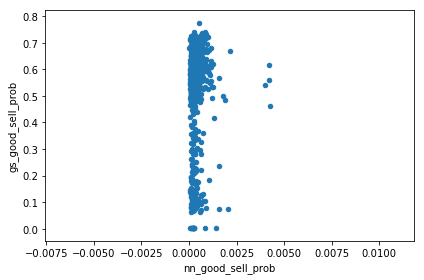

In [13]:
url = plot_rounds(c.query('gs_good_sell_prob > 0.00').plot.scatter(x='nn_good_sell_prob', y='gs_good_sell_prob'))
slack("", url, "Model Correlation")

In [14]:
for_sale = pd.read_csv('CSV_backups/ALL-for_sale.csv', index_col=['property_id','transaction_id'])
for_sale['zipcode'] = for_sale.zipcode.apply(str)

In [15]:
from math import radians, cos, sin, asin, sqrt
def haversine(row, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    lon1 = row.longitude
    lat1 = row.latitude
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km / 1.60934 # convert to miles

In [16]:
for r, target in d.iterrows():
    print(target.name[0])
    print(target.address)
    target.longitude = for_sale.loc[target.name].longitude
    target.latitude = for_sale.loc[target.name].latitude
    
    # get all properties listed for sale in the same zipcode as our target
    z = for_sale[(for_sale.zipcode == target.zipcode)]
    print(len(z.longitude))
    
    z['dist'] = z.apply(haversine, lon2 = target.longitude, lat2 = target.latitude, axis=1)
    print(z[['address','dist']].nsmallest(5,'dist'))
    

NameError: name 'd' is not defined

In [ ]:
d

In [ ]:
d.head()